<a href="https://colab.research.google.com/github/physicaone/loss_IG/blob/master/%5B210902%5Dvisual_result8_sym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.utils.data
import torch.nn as nn
from tqdm import tqdm, tnrange
import warnings
warnings.filterwarnings("ignore")
import random
import pickle as pkl
import pandas as pd
from scipy.stats import entropy
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
CUDA = torch.cuda.is_available()
CUDA_DEVICE = 0

try:
    from google.colab import drive
    drive.mount('/content/drive')
    base='drive/MyDrive'
except:
    if torch.cuda.device_count()>1:
        base='.'
    else:
        base='Google Drive'

if CUDA:
    device='cuda'
else:
    device='cpu'
torch.cuda.is_available()

Mounted at /content/drive


False

In [2]:
def decimal_to_binary(integer, n_hid):
    string=bin(int(integer))[2:]
    list0=[float(d) for d in string]
    while len(list0)<n_hid:
        list0=[0.]+list0
    return torch.tensor([list0])

def Ising_energy(v_list):
    L = 3
    E_list=[]
    for n in range(len(v_list)):
        v=v_list[n]
        E = 0
        for i in range(L):
            for j in range(L):
                s = v[i,j]
                neigh = v[(i+1)%L, j] + v[i,(j+1)%L] + v[(i-1)%L,j] + v[i,(j-1)%L] 
                E += -neigh * s
        E_list.append(E/2)
    return np.array(E_list)
    
class RBM(nn.Module):

    def __init__(self, n_vis, n_hid, k):
        """Create a RBM."""
        super(RBM, self).__init__()
        
        self.v_bias = nn.Parameter(torch.zeros(1, n_vis).to(device))
        self.h_bias = nn.Parameter(torch.zeros(1, n_hid).to(device))
        self.Weight = nn.Parameter(torch.randn(n_hid, n_vis).to(device)*0.5)
        self.k = k


    def v2h(self, v):
        return torch.sigmoid(F.linear(v, self.Weight, self.h_bias))

    def h2v(self, h):
        return torch.sigmoid(F.linear(h, self.Weight.t(), self.v_bias))
    
    def Fv(self, v):
        v_term = torch.matmul(v, self.v_bias.t()).view(len(v))
        h_term = torch.sum(F.softplus(F.linear(v, self.Weight, self.h_bias)), dim=1)
        return -h_term -v_term

    def energy(self, v, h):
        v=v.bernoulli()
        h=h.bernoulli()
        return -torch.matmul(v, self.v_bias.t())-torch.matmul(torch.matmul(v, self.Weight.t()),h.t())-torch.matmul(h, self.h_bias.t())
    
    def Energy_GPU2(self, v_list0, h_list0):
        if CUDA:
            n_split=torch.cuda.device_count()
        else:
            n_split=1
        e_list=[]
        m_split=2**6
        for j in range(m_split):
            v_list1=torch.stack(list(v_list0[j*int(len(v_list0)/m_split):(j+1)*int(len(v_list0)/m_split)]))
            h_list1=torch.stack(list(h_list0[j*int(len(h_list0)/m_split):(j+1)*int(len(h_list0)/m_split)]))
            vs=[]
            hs=[]
            for i in range(n_split):
                v_list2=torch.stack(list(v_list1[i*int(len(v_list1)/n_split):(i+1)*int(len(v_list1)/n_split)]))
                h_list2=torch.stack(list(h_list1[i*int(len(h_list1)/n_split):(i+1)*int(len(h_list1)/n_split)]))
                if CUDA:
                    v_list2=v_list2.to(device='cuda:' + str(i)).view(len(v_list2), n_vis)
                    h_list2=h_list2.to(device='cuda:' + str(i)).view(len(h_list2), n_hid)
                else:
                    None
                vs.append(v_list2)
                hs.append(h_list2)
            for i in range(n_split): 
                if CUDA:
                    a=self.v_bias.to(device='cuda:' + str(i)).view(n_vis)
                    b=self.h_bias.to(device='cuda:' + str(i)).view(n_hid)
                    W=self.Weight.to(device='cuda:' + str(i)).view(n_hid, n_vis)
                    e=(-torch.matmul(vs[i].float(), a)-torch.diagonal(torch.matmul(torch.matmul(vs[i].float(), W.t()), hs[i].float().t()))-torch.matmul(hs[i].float(), b)).to('cuda:0')
                    e_list.append(e)
                else:
                    a=self.v_bias.view(n_vis)
                    b=self.h_bias.view(n_hid)
                    W=self.Weight.view(n_hid, n_vis)
                    e=(-torch.matmul(vs[i].float(), a)-torch.diagonal(torch.matmul(torch.matmul(vs[i].float(), W.t()), hs[i].float().t()))-torch.matmul(hs[i].float(), b))
                    e_list.append(e)
        return torch.stack(e_list).view(len(v_list0))
    
    def forward(self, v):
        h = self.v2h(v)
        h = h.bernoulli()
        for _ in range(self.k):
            v_gibbs = self.h2v(h).to(device)
            v_gibbs = v_gibbs.bernoulli()
            h = self.v2h(v_gibbs).to(device)
            h = h.bernoulli()
        return v, v_gibbs
        

In [98]:
def CM(list0):
    list1=np.reshape(np.array(list0),(3,3))
    max_x=0; max_y=0
    for i in range(3):
        for j in range(3):
            if list1[i][j]>list1[max_x][max_y]:
                max_x=i; max_y=j
    dx=0; dy=0
    for i in [-1,1]:
        for j in [-1,1]:
            dx+=list1[(max_x+i+3)%3][(max_y+j+3)%3]*(i)/list1[max_x][max_y]
            dy+=list1[(max_x+i+3)%3][(max_y+j+3)%3]*(j)/list1[max_x][max_y]
    x=max_x+dx
    y=max_y+dy
    if x<0: x=x+3
    if y<0: y=y+3
    return x, y

In [5]:
# Hyper parameter들을 설정
n_vis=9
k=5
lr=0.1
vol=512
batch_size=int(vol/2)
epoch_to_save=[2**i for i in range(20)]
n_epochs=epoch_to_save[-1]+1
n_hid_list=[6]
T_list=[16]
T_color=['red', 'orange', 'green', 'blue', 'purple']
n_hid_color=['darkred','red', 'orange', 'yellow', 'yellowgreen', 'green', 'skyblue', 'blue','darkblue','pink', 'purple', 'black']
lr=0.1
std=0.5

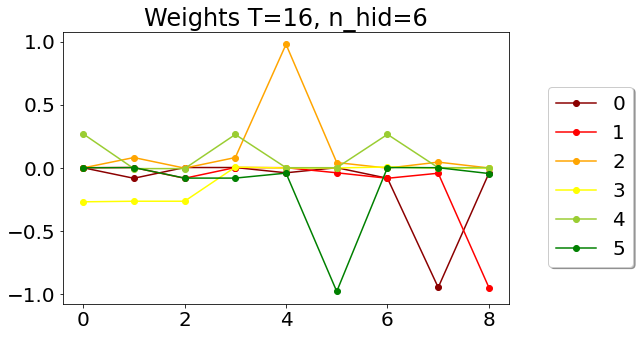

In [6]:

plt.figure(figsize=(8,5))

n_vis=9
Weights={}
for T in T_list:
    Weights[str(T)]={}
    for n_hid in n_hid_list:
        # Weights[str(T)][str(n_hid)]=torch.tensor([0.]*n_vis*n_hid)
        models=pd.read_pickle('{base}/loss_IG/3*3/Exact_state_dict/model_n_hid={n_hid}_T={T}_sym.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
        Weights[str(T)][str(n_hid)]=(models[str(9)][-1]['Weight'].t())
#         for m in range(1,10):
#             Weights[str(T)][str(n_hid)]+=(models[str(m)][-1]['Weight'].t())/10
        Weights[str(T)][str(n_hid)]=np.array(Weights[str(T)][str(n_hid)])
for i in range(1, len(n_hid_list)+1):
    n_hid=str(n_hid_list[i-1])
#         plt.subplot(2, 4, i)
    plt.rcParams["font.size"] = "20"
    plt.title('Weights T={T}, n_hid={n_hid}'.format(T=T,n_hid=n_hid))
    # plt.xlim(-20, 20)
    # plt.ylim(0, 50)
    for n in range(int(n_hid)):
        for t in range(len(T_list)):
            WP=[]
            for j in range(n_vis):
                WP.append(Weights[str(T_list[t])][n_hid][j][n])
            plt.plot(range(n_vis),np.array(WP), c=n_hid_color[n], label = n, marker='o')
#             plt.pcolor(Weights[str(T_list[t])][n_hid])




#     plt.savefig('{base}/loss_IG/3*3/imgs/{j}.png'.format(base=base, j=j))

#     plt.yscale('log')
#     plt.ylim(0, 1400)
    plt.legend(loc='lower right', bbox_to_anchor=(1.3, 0.1), ncol=1, fancybox=True, shadow=True)
    # plt.ylim(1, 10000)

In [104]:

plt.figure(figsize=(8,5))

n_vis=9
Weights={}
CMs={}
for T in T_list:
    CMs[str(T)]={}
    for n_hid in n_hid_list:
        CMs[str(T)][str(n_hid)]=[]
        models=pd.read_pickle('{base}/loss_IG/3*3/Exact_state_dict/model_n_hid={n_hid}_T={T}_sym.pkl'.format(base=base, n_hid=n_hid, T=T, lr=lr, vol=vol, std=std))
        for n in range(n_hid):
            CMs[str(T)][str(n_hid)].append(CM(models[str(0)][-1]['Weight'][n]))


<Figure size 576x360 with 0 Axes>

In [105]:
CMs

{'16': {'6': [(0.5526090719412661, 1.5526077607888178),
   (0.2324109122157548, 2.9138080915429447),
   (-29.02387586172027, -28.023023957068943),
   (1.7059885696410682, -9.826493341604792),
   (0.6271119049920124, 2.9358088406373324),
   (1.9357491081387863, 1.6271702458749464)]}}